# Урок 6. Градиентный бустинг

## Реализация алгоритма градиентного бустинга

Реализуем средствами Python алгоритм градиентного бустинга для деревьев решений.

Реализация деревьев решений была дважды продемонстрирована в предыдущих уроках, в этом не будем ее повторять и возьмем готовую реализацию дерева решений для регрессии из библиотеки `sklearn`.

In [1]:
from sklearn.tree import DecisionTreeRegressor

from sklearn import model_selection
import numpy as np

Используем один из "игрушечных" датасетов из той же библиотеки.

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)

Разделим выборку на обучающую и тестовую в соотношении 75/25.

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Напишем функцию, реализующую предсказание в градиентном бустинге.

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании прибавляются с шагом eta
    return np.array([sum([eta* coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) for x in X])

В качестве функционала ошибки будем использовать среднеквадратичную ошибку. Реализуем соответствующую функцию.

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction)**2)) / len(y_real)

Используем $L_{2}$ loss $L(y, z) = (y-z)^{2},$ ее производная по $z$ примет вид $L'(y, z) = 2(z-y)$. Реализуем ее также в виде функции (коэффициент 2 можно отбросить).

In [7]:
def bias(y, z):
    return (y - z)

Реализуем функцию обучения градиентного бустинга.

In [8]:
def gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta):
    
    # Деревья будем записывать в список
    trees = []

    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)

        else:
            # Получим ответы на текущей композиции
            target = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы начиная со второго обучаем на сдвиг
            tree.fit(X_train, bias(y_train, target))

        trees.append(tree)
        
    return trees

In [9]:
import matplotlib.pyplot as plt

In [10]:
def get_error_plot(n_trees, train_err, test_err):
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plt.xlim(0, n_trees)
    plt.plot(list(range(n_trees)), train_err, label='train error')
    plt.plot(list(range(n_trees)), test_err, label='test error')
    plt.legend(loc='upper right')
    plt.show()

# 1. Для реализованной в методичке модели градиентного бустинга построить графики зависимости ошибки от количества деревьев в ансамбле и от максимальной глубины деревьев. Сделать выводы о зависимости ошибки от этих параметров.

In [11]:
def gb_fit_predict(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    
    trees = gb_fit(n_trees, max_depth, X_train, y_train, coefs, eta)
    
    train_prediction = gb_predict(X_train, trees, coefs, eta)
    test_prediction  = gb_predict(X_test,  trees, coefs, eta)
    
    train_mse = mean_squared_error(y_train, train_prediction)
    test_mse  = mean_squared_error(y_test,  test_prediction )
    
    return train_mse, test_mse

In [12]:
eta = 1
n_trees = np.arange(3,13)
max_depth = np.arange(1,10)
x_n_trees, y_max_depth = np.meshgrid(n_trees, max_depth, sparse=False)
xy = list(zip(x_n_trees.flatten(), y_max_depth.flatten()))

In [13]:
mse = [gb_fit_predict(x, y, X_train, X_test, y_train, y_test, [1]*x, eta) for x,y in xy]

In [14]:
def get_z(index):
    return np.array(list(map(lambda t: t[index], mse))).reshape(x_n_trees.shape)

z_train_mse, z_test_mse = get_z(0), get_z(1)

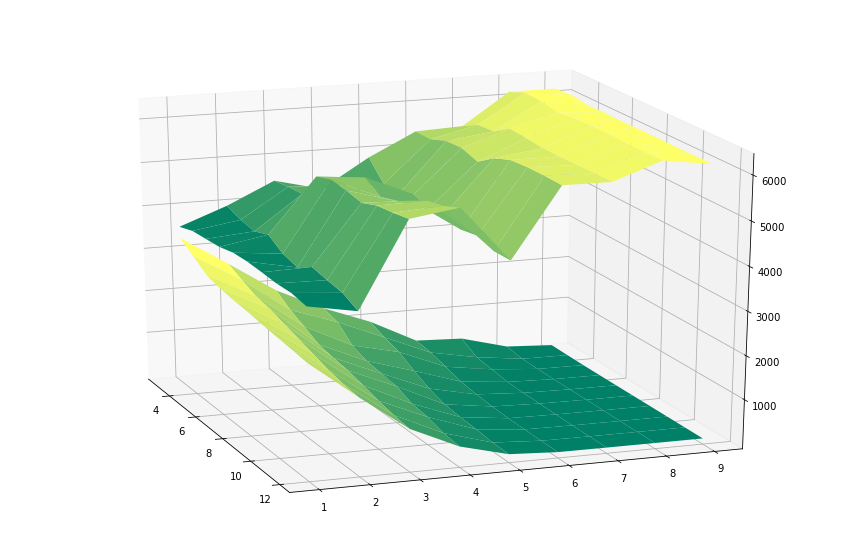

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_n_trees, y_max_depth, z_train_mse, cmap='summer')
ax.plot_surface(x_n_trees, y_max_depth, z_test_mse, cmap='summer')
ax.view_init(20, -20)


Из графика видно:
* увеличение max_depth сводит к нулю ошибку на тренировочной выборке, а на тестовой - наоборот увеличивает ошибку. То есть увеличение параметра max_depth очень сильно влияет на переобучение.
* увеличение числа деревьев стабильно (но не быстро) снижает ошибку на тренировочной выборке, а на тестовой - слабо влияет на величину ошибки.
* оптимальные параметры в данном случае: max_depth = 2, n_trees = 6.

# 2*. Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5. Cравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

Постараюсь доделать